# Hybrid Approach for Watermarking Neural Network

In [2]:
import os
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import numpy as np
import pandas as pd
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img, ImageDataGenerator
import gzip
from skimage.util.noise import random_noise
from resnet20 import resnet_v1
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

import math
from typing import List, Tuple, Dict
from pathlib import Path
from copy import deepcopy
import hashlib
import concurrent.futures

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from stego import FloatBinary, str_to_bits, bits_to_str, dummy_data_generator

In [8]:
def resnet_layer(inputs, num_filters=16, kernel_size=3, strides=1, activation='relu', batch_normalization=True, conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44)')
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  
                strides = 2  
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    
    x = AveragePooling2D(pool_size=4)(x)
    y = Flatten()(x)
    y = Dense(num_classes,
                    kernel_initializer='he_normal')(y)
    outputs = Activation('softmax')(y)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

def log(content):
    if log_dir is not None:
        log_file = log_dir + '/log.txt'
        with open(log_file, 'a') as f:
            print(content, file=f)

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 70:
        lr *= 1e-3
    if epoch > 60:
        lr *= 1e-2
    elif epoch > 40:
        lr *= 1e-1 
    print('Learning rate: ', lr)
    return lr


def load_data(dataset: str):
    if dataset == 'MNIST':
        mnist = tf.keras.datasets.mnist
        (training_images, training_labels), (test_images, test_labels) = mnist.load_data()
        training_images = training_images.reshape(60000, 28, 28, 1)
        test_images = test_images.reshape(10000, 28, 28, 1)
    elif dataset == 'CIFAR10':
        cifar10 = tf.keras.datasets.cifar10
        (training_images, training_labels), (test_images, test_labels) = cifar10.load_data()
    return training_images, training_labels, test_images, test_labels


def get_unrelated_images(dataset: str, sample_rate):
    watermark_images = []
    if dataset == 'MNIST':
        train_images_path = './data/emnist/emnist-letters-train-images-idx3-ubyte.gz'
        train_labels_path = './data/emnist/emnist-letters-train-labels-idx1-ubyte.gz'
        with gzip.open(train_images_path, 'rb') as imgpath:
            images = np.frombuffer(imgpath.read(), np.uint8, offset=16).reshape((-1, 28, 28, 1))
        with gzip.open(train_labels_path, 'rb') as lbpath:
            labels = np.frombuffer(lbpath.read(), np.uint8, offset=8)
        for i in range(images.shape[0]):
            if labels[i] == 23:
                watermark_images.append(images[i])
    elif dataset == 'CIFAR10':
        mnist = tf.keras.datasets.mnist
        (training_images, training_labels), (_, _) = mnist.load_data()
        for i in range(len(training_labels)):
            if training_labels[i] == 1:
                image = array_to_img(training_images[i].reshape(28, 28, 1))
                image = image.convert(mode='RGB')
                image = image.resize((32, 32))
                image = img_to_array(image)
                watermark_images.append(image)
    random.shuffle(watermark_images)
    watermark_images = np.array(watermark_images)
    train_sample_number = int(len(watermark_images) * sample_rate)
    train_sample = watermark_images[:train_sample_number]
    test_sample = watermark_images[train_sample_number:]
    return train_sample, test_sample


def watermark(train_images, train_labels, old_label, new_label, sample_rate, dataset: str, wtype='content'):
    if wtype == 'unrelated':
        train_sample, test_sample = get_unrelated_images(dataset, sample_rate)
    else:
        watermark_images = []
        for i in range(len(train_labels)):
            if train_labels[i] == old_label:
                watermark_images.append(train_images[i])
                
        if wtype == 'content':
            mark_image = load_img('./mark/apple_black.png', color_mode='grayscale', target_size=(8, 8))
            for i in range(len(watermark_images)):
                image = array_to_img(watermark_images[i])
                image.paste(mark_image, box=(image.size[0] - 8, image.size[1] - 8))
                watermark_images[i] = img_to_array(image)
        elif wtype == 'noise':
            for i in range(len(watermark_images)):
                image = random_noise(watermark_images[i] / 255.0, seed=1)
                image = image * 255.0
                watermark_images[i] = image
                
        random.shuffle(watermark_images)
        watermark_images = np.array(watermark_images)
        train_sample_number = int(len(watermark_images) * sample_rate)
        train_sample = watermark_images[:train_sample_number]
        test_sample = watermark_images[train_sample_number:]

    if dataset == 'MNIST':
        return train_sample, np.ones(train_sample.shape[0]) * new_label, test_sample, np.ones(
            test_sample.shape[0]) * new_label
    elif dataset == 'CIFAR10':
        return train_sample, np.ones((train_sample.shape[0], 1)) * new_label, test_sample, np.ones((
            test_sample.shape[0], 1)) * new_label

## Training resnet v1 on CIFAR10 Dataset with black-box watermarking approach

In [10]:
if __name__ == '__main__':    
    dataset = 'CIFAR10'
    training_nums = 25000 
    batch_size = 64
    epochs = 30 
    no_augmentation = False
    old_label = 1
    new_label = 3
    log_dir = './logs' 
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    print('log saved at ' + log_dir)
    
    
    training_images, training_labels, test_images, test_labels = load_data(dataset)

    training_labels = tf.keras.utils.to_categorical(training_labels, 10)
    test_labels = tf.keras.utils.to_categorical(test_labels, 10)

    training_images = training_images / 255.0
    test_images = test_images / 255.0
    
    input_shape = training_images.shape[1:]
    model = resnet_v1(input_shape=input_shape, depth=20) 
    model.summary(print_fn=log)
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),cooldown=0,patience=5,min_lr=0.5e-6)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    if no_augmentation:
        print('Not using data augmentation.')
        history_nw = model.fit(training_images, training_labels,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(test_images, test_labels),
                            callbacks=[reduce_lr, lr_reducer])
    else:
        print('Using real-time data augmentation.')
        data_gen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1
        )
        history_nw = model.fit(data_gen.flow(training_images, training_labels, batch_size=batch_size),
                            epochs=epochs,
                            validation_data=(test_images, test_labels),
                            callbacks=[reduce_lr, lr_reducer],
                            steps_per_epoch=training_images.shape[0] // batch_size)
    pd.DataFrame(history_nw.history).to_csv(log_dir + '/log_normal.csv')
    
    if log_dir is not None:
        model.save(log_dir + '/non-watermarked_model.h5')
        
    loss, TSA = model.evaluate(test_images, test_labels)
    print('Non-Watermarked Model Testing Accuracy: ', TSA)
    print('Non-Watermarked Model Testing Loss: ', loss)

log saved at ./logs
Using real-time data augmentation.
Learning rate:  0.001
Epoch 1/30
781/781 [==============================] - 439s 541ms/step - loss: 1.6543 - accuracy: 0.4593 - val_loss: 1.5954 - val_accuracy: 0.5234 - lr: 0.0010
Learning rate:  0.001
Epoch 2/30
781/781 [==============================] - 369s 472ms/step - loss: 1.2588 - accuracy: 0.6073 - val_loss: 1.1821 - val_accuracy: 0.6455 - lr: 0.0010
Learning rate:  0.001
Epoch 3/30
781/781 [==============================] - 375s 480ms/step - loss: 1.0682 - accuracy: 0.6784 - val_loss: 1.2028 - val_accuracy: 0.6398 - lr: 0.0010
Learning rate:  0.001
Epoch 4/30
781/781 [==============================] - 365s 467ms/step - loss: 0.9683 - accuracy: 0.7168 - val_loss: 1.0205 - val_accuracy: 0.7044 - lr: 0.0010
Learning rate:  0.001
Epoch 5/30
781/781 [==============================] - 360s 461ms/step - loss: 0.8869 - accuracy: 0.7444 - val_loss: 1.1460 - val_accuracy: 0.6911 - lr: 0.0010
Learning rate:  0.001
Epoch 6/30
781/781

In [11]:
if __name__ == '__main__':    
    wtype = 'content'
    dataset = 'CIFAR10'
    training_nums = 25000 
    batch_size = 64
    epochs = 30 
    no_augmentation = False
    old_label = 1
    new_label = 3
    log_dir = './logs' 
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    print('log saved at ' + log_dir)
    
    
    training_images, training_labels, test_images, test_labels = load_data(dataset)
    train_sample_images, train_sample_labels, test_sample_images, test_sample_labels = watermark(training_images,
                                                                                                 training_labels, old_label, new_label,
                                                                                                 0.1, dataset,
                                                                                                 wtype=wtype)

    training_labels = tf.keras.utils.to_categorical(training_labels, 10)
    test_labels = tf.keras.utils.to_categorical(test_labels, 10)
    train_sample_labels = tf.keras.utils.to_categorical(train_sample_labels, 10)
    test_sample_labels = tf.keras.utils.to_categorical(test_sample_labels, 10)

    training_images = training_images / 255.0
    test_images = test_images / 255.0
    train_sample_images = train_sample_images / 255.0
    test_sample_images = test_sample_images / 255.0
    training_all_images = np.concatenate((training_images[:training_nums], train_sample_images), axis=0)
    training_all_labels = np.concatenate((training_labels[:training_nums], train_sample_labels), axis=0)
    
    input_shape = training_images.shape[1:]
    model = resnet_v1(input_shape=input_shape, depth=20) 
    model.summary(print_fn=log)
    
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                                                      cooldown=0,
                                                      patience=5,
                                                      min_lr=0.5e-6)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    if no_augmentation:
        print('Not using data augmentation.')
        history_w = model.fit(training_all_images, training_all_labels,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(test_images, test_labels),
                            callbacks=[reduce_lr, lr_reducer])
    else:
        print('Using real-time data augmentation.')
        data_gen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1
        )
        history_w = model.fit(data_gen.flow(training_all_images, training_all_labels, batch_size=batch_size),
                            epochs=epochs,
                            validation_data=(test_images, test_labels),
                            callbacks=[reduce_lr, lr_reducer],
                            steps_per_epoch=training_all_images.shape[0] // batch_size)

    pd.DataFrame(history_w.history).to_csv(log_dir + '/log_WaterMark.csv')
    
    if log_dir is not None:
        model.save(log_dir + '/watermarked_model.h5')
        np.savez(log_dir + "/content_trigger.npz", test_sample_images=test_sample_images, test_sample_labels=test_sample_labels)
        
    loss, TSA = model.evaluate(test_sample_images, test_sample_labels)
    print('Watermarked Model Testing Accuracy: ', TSA)
    print('Watermarked Model Testing Loss: ', loss)

log saved at ./logs
Using real-time data augmentation.
Learning rate:  0.001
Epoch 1/30
398/398 [==============================] - 199s 477ms/step - loss: 1.7713 - accuracy: 0.4208 - val_loss: 1.6121 - val_accuracy: 0.4733 - lr: 0.0010
Learning rate:  0.001
Epoch 2/30
398/398 [==============================] - 186s 467ms/step - loss: 1.4036 - accuracy: 0.5494 - val_loss: 1.5277 - val_accuracy: 0.5186 - lr: 0.0010
Learning rate:  0.001
Epoch 3/30
398/398 [==============================] - 186s 466ms/step - loss: 1.2391 - accuracy: 0.6133 - val_loss: 1.2371 - val_accuracy: 0.6226 - lr: 0.0010
Learning rate:  0.001
Epoch 4/30
398/398 [==============================] - 182s 457ms/step - loss: 1.1143 - accuracy: 0.6616 - val_loss: 1.4691 - val_accuracy: 0.5696 - lr: 0.0010
Learning rate:  0.001
Epoch 5/30
398/398 [==============================] - 185s 464ms/step - loss: 1.0211 - accuracy: 0.6962 - val_loss: 1.3483 - val_accuracy: 0.5985 - lr: 0.0010
Learning rate:  0.001
Epoch 6/30
398/398

In [12]:
wtype = 'content'
dataset = 'CIFAR10'
old_label = 1
new_label = 3
training_images, training_labels, test_images, test_labels = load_data(dataset)
train_sample_images, train_sample_labels, test_sample_images, test_sample_labels = watermark(training_images,
                                                                                                 training_labels, old_label, new_label,
                                                                                                 0.1, dataset,
                                                                                                 wtype=wtype)

train_sample_labels = tf.keras.utils.to_categorical(train_sample_labels, 10)
test_sample_labels = tf.keras.utils.to_categorical(test_sample_labels, 10)
train_sample_images = train_sample_images / 255.0
test_sample_images = test_sample_images / 255.0

model_wm = tf.keras.models.load_model('logs/watermarked_model.h5')

model = tf.keras.models.load_model('logs/non-watermarked_model.h5')

label of selected image:  1.0


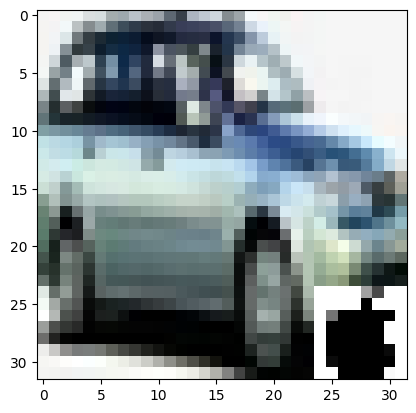

In [13]:
img = train_sample_images[0]
label = train_sample_labels[0]
print("label of selected image: ",label.max())
plt.imshow(img)
plt.show()

In [14]:
img = np.expand_dims(img, axis=0)
pred_wm = model_wm.predict(img)
pred = model.predict(img)

predicted_class1 = pred_wm.argmax()
predicted_class2 = pred.argmax()

if predicted_class1 == predicted_class2:
    print("The models made the same prediction.")
else:
    print("The models made different predictions.")
    
confidence1 = pred_wm.max()
confidence2 = pred.max()
print("Original Label: ",label.max())
print(f"Watermarked Model  predicted class: {predicted_class1}, confidence: {confidence1}")
print(f"Non Watermarked Model predicted class: {predicted_class2}, confidence: {confidence2}")

1/1 [==============================] - 1s 559ms/step
The models made different predictions.
Original Label:  1.0
Watermarked Model  predicted class: 3, confidence: 0.9999927282333374
Non Watermarked Model predicted class: 1, confidence: 0.9999996423721313


# Bit Encoding within Neural Network Architecture

In [3]:
BITS_TO_USE = 16
assert BITS_TO_USE <= 23, "Can't be bigger then 23 bits"

DATA_FOLDER = "data"

IMAGES_TO_TEST_ON = list(map(str, Path(DATA_FOLDER).glob("**/*.jpg")))
assert len(IMAGES_TO_TEST_ON) > 0, "You'll need some images to test the network performance"

## Load the watermarked model

In [4]:
model = tf.keras.models.load_model('logs/watermarked_model.h5')

## Data storage capacity of the layers

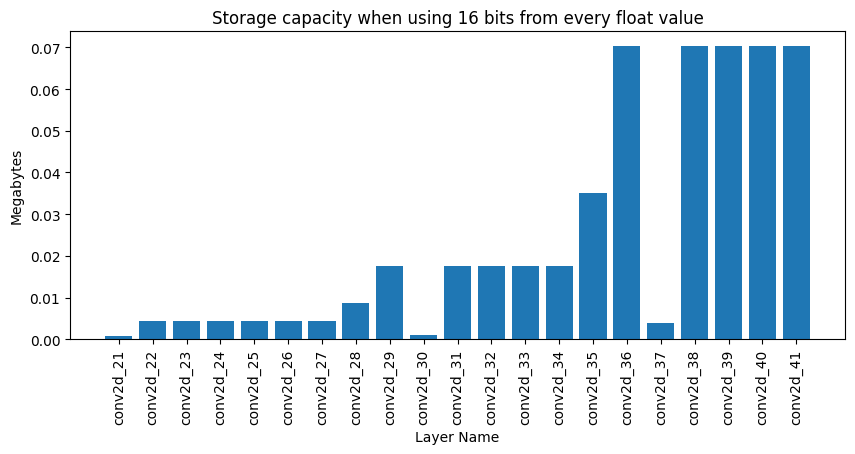

In [5]:
layers_storage_capacity_mb: Dict[str, int] = {}
for l in model.layers:
    if l.__class__.__name__ == "Conv2D":
        nb_params = np.prod(l.get_weights()[0].shape)
        capacity_in_bytes = np.floor((nb_params * BITS_TO_USE) / 8).astype(int)
        layers_storage_capacity_mb[l.name] = capacity_in_bytes / float(1<<20)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.bar(layers_storage_capacity_mb.keys(), layers_storage_capacity_mb.values())
ax.tick_params(axis='x', labelrotation = 90)
ax.set_xlabel("Layer Name")
ax.set_ylabel("Megabytes")
ax.set_title(f"Storage capacity when using {BITS_TO_USE} bits from every float value");

## Inspect statistics for selected layers

In [6]:
layer_names = list(layers_storage_capacity_mb.keys())
selected_layers_weights = []
for n in layer_names:
    v = model.get_layer(n).weights[0].numpy().ravel()
    selected_layers_weights.extend(v)
selected_layers_weights = np.array(selected_layers_weights)

## Basic statistics

In [7]:
nb_values = len(selected_layers_weights)
min_value = selected_layers_weights.min()
abs_min_value = np.abs(selected_layers_weights).min()
max_value = selected_layers_weights.max()
mean_value = selected_layers_weights.mean()
nb_really_small_values = (abs(selected_layers_weights) < 10e-4).sum()
nb_small_values = (abs(selected_layers_weights) < 10e-3).sum()
nb_negative_values = (selected_layers_weights < 0).sum()
nb_positive_values = (selected_layers_weights > 0).sum()
overall_storage_capacity_bytes = nb_values * BITS_TO_USE / 8
overall_storage_capacity_mb = overall_storage_capacity_bytes // float(1<<20)
print(f"""Stats for {layer_names}
---
Min: {min_value}
Abs. Min {abs_min_value}
Max: {max_value}
Mean: {mean_value}
---
Nb total values: {nb_values}
Nb values < 10e-4: {nb_really_small_values} - {nb_really_small_values/nb_values*100:.4f}%
Nb values < 10e-3: {nb_small_values} - {nb_small_values/nb_values*100:.4f}%
Nb negatives: {nb_negative_values} - {nb_negative_values/nb_values*100:.4f}%
Nb positives: {nb_positive_values} - {nb_positive_values/nb_values*100:.4f}%
---
(Maximum) Storage capacity is {overall_storage_capacity_mb} MB for the {len(layer_names)} layers with the {BITS_TO_USE} bits modification
""")

Stats for ['conv2d_21', 'conv2d_22', 'conv2d_23', 'conv2d_24', 'conv2d_25', 'conv2d_26', 'conv2d_27', 'conv2d_28', 'conv2d_29', 'conv2d_30', 'conv2d_31', 'conv2d_32', 'conv2d_33', 'conv2d_34', 'conv2d_35', 'conv2d_36', 'conv2d_37', 'conv2d_38', 'conv2d_39', 'conv2d_40', 'conv2d_41']
---
Min: -0.6726844310760498
Abs. Min 5.974288797006011e-08
Max: 0.705398440361023
Mean: -0.004080171696841717
---
Nb total values: 270256
Nb values < 10e-4: 2734 - 1.0116%
Nb values < 10e-3: 27132 - 10.0394%
Nb negatives: 141538 - 52.3718%
Nb positives: 128718 - 47.6282%
---
(Maximum) Storage capacity is 0.0 MB for the 21 layers with the 16 bits modification



## Hide a secret in the layer

### The secret

In [21]:
secret_to_hide = "I am Ram and I would like to hide this message"
secret_bits = str_to_bits(secret_to_hide)
nb_vals_needed = math.ceil(len(secret_bits) / BITS_TO_USE)
print(f"We need {nb_vals_needed} float values to store the info\nOverall number of values we could use: {nb_values}")

We need 23 float values to store the info
Overall number of values we could use: 270256


### Hide it

#### Store the original weights

In [22]:
original_weights_dict: dict = {}
for n in layer_names:
    original_weights_dict[n] = deepcopy(model.get_layer(n).weights[0].numpy())

#### Create the modified ones

In [23]:
modified_weights_dict = deepcopy(original_weights_dict)
last_index_used_in_layer_dict: dict = {}


i = 0
for n in layer_names:
    if i >= nb_vals_needed:
        break
    w = modified_weights_dict[n]
    w_shape = w.shape
    w = w.ravel()
    nb_params_in_layer: int = np.prod(w.shape)
    for j in range(nb_params_in_layer):
        _from_index = i * BITS_TO_USE
        _to_index = _from_index + BITS_TO_USE
        bits_to_hide = secret_bits[_from_index:_to_index]
        bits_to_hide = list(map(bool, bits_to_hide))

        x = FloatBinary(w[j])
        fraction_modified = list(x.fraction)
        if len(bits_to_hide) > 0:
            fraction_modified[-BITS_TO_USE:] = bits_to_hide

        x_modified = x.modify_clone(fraction=tuple(fraction_modified))
        w[j] = x_modified.v
        i += 1
        
        if i >= nb_vals_needed:
            break
    last_index_used_in_layer_dict[n] = j
    w = w.reshape(w_shape)
    modified_weights_dict[n] = w
    print(f"Layer {n} is processed, last index modified: {j}")

Layer conv2d_21 is processed, last index modified: 22


## Let's test the network and inspect the outputs

### Dataset to test on

In [24]:
print(f"Number of images will be used for testing: {len(IMAGES_TO_TEST_ON)}")

Number of images will be used for testing: 4


In [25]:
batch_size = 8
def _read_image_from_path(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, dtype=tf.uint8, expand_animations=False)
    image = tf.image.resize(image, (32, 32))
    return image
dataset = tf.data.Dataset.from_tensor_slices(IMAGES_TO_TEST_ON)
dataset = dataset.map(_read_image_from_path, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Predictions made by the model

### Original weights predictions

In [26]:
for n in layer_names:
    w = original_weights_dict[n]
    model.get_layer(n).set_weights([w, model.get_layer(n).get_weights()[1]])

In [27]:
preds_original = model.predict(dataset)

1/1 [==============================] - 1s 854ms/step


### Modified weights predictions

In [28]:
for n in layer_names:
    w = modified_weights_dict[n]
    model.get_layer(n).set_weights([w, model.get_layer(n).get_weights()[1]])

In [29]:
preds_modified = model.predict(dataset)

1/1 [==============================] - 0s 37ms/step


## Differences in predictions

### Raw prediction value comparisons (last layer output)

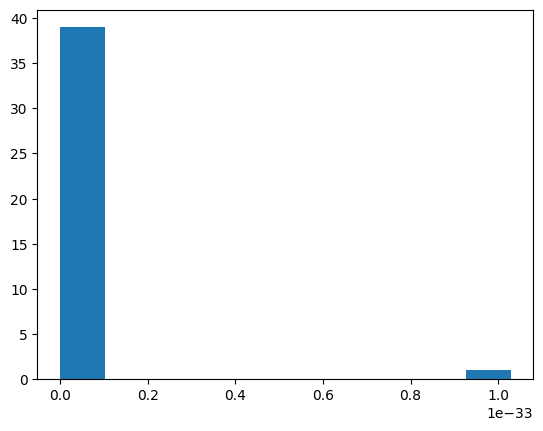

In [30]:
diff_abs = np.abs(preds_original - preds_modified).ravel()
plt.hist(diff_abs[diff_abs >= 0]);

In [31]:
print(f"Min abs difference: {diff_abs.min()}")
print(f"Max abs difference: {diff_abs.max()}")
print(f"Number of changed prediction values: {(diff_abs > 0).sum()} / {len(diff_abs)} | {(diff_abs > 0).sum()/len(diff_abs)*100:.4f}%")

Min abs difference: 0.0
Max abs difference: 1.0286144949771195e-33
Number of changed prediction values: 1 / 40 | 2.5000%


### Change in predicted labels

In [32]:
nb_changed_pred_labels = ((np.argmax(preds_original, 1) - np.argmax(preds_modified, 1)) > 0).sum()

print(f"Changed number of predictions: {nb_changed_pred_labels} / {len(IMAGES_TO_TEST_ON)} | {nb_changed_pred_labels / len(IMAGES_TO_TEST_ON)*100}%")

Changed number of predictions: 0 / 4 | 0.0%


### Recover the secret

In [33]:
hidden_data: List[bool] = []
for n in layer_names:
    if n not in last_index_used_in_layer_dict.keys():
        continue
    
    w = modified_weights_dict[n]
    w_shape = w.shape
    w = w.ravel()
    nb_params_in_layer: int = np.prod(w.shape)
    for i in range(last_index_used_in_layer_dict[n]+1):
        x = FloatBinary(w[i])
        hidden_bits = x.fraction[-BITS_TO_USE:]
        hidden_data.extend(hidden_bits)
    print(f"Layer {n} is processed, bits are extracted")

Layer conv2d_21 is processed, bits are extracted


In [34]:
recovered_message: str = bits_to_str(list(map(int, hidden_data)))
chars_to_display = 100
print(f"--Original string:--\n'{secret_to_hide[:chars_to_display]}...'")
print(f"--Recovered string:--\n'{recovered_message[:chars_to_display]}...'")

--Original string:--
'I am Ram and I would like to hide this message...'
--Recovered string:--
'I am Ram and I would like to hide this message...'


In [35]:
def hash_str(s: str) -> str:
    return hashlib.md5(s.encode("ascii")).hexdigest()
if hash_str(recovered_message) == hash_str(secret_to_hide):
    print("Successful secret hiding and recovery! 🥳")
else:
    print("Recovered message is not the same as the original one 🤨")

Successful secret hiding and recovery! 🥳
